In [1]:
%reload_ext autoreload
%autoreload 2

import mlflow
import os
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import xgboost as xgb

from loguru import logger
from matplotlib import pyplot as plt
from pathlib import Path
from pycaret import regression
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


sys.path.append(str(Path.cwd().parent))
sys.path.append(os.path.join(str(Path.cwd().parent), "src"))
from evaluate import evaluate_models
from plot import prediction_error_plot, residual_plot
from settings.params import *
from tuning import fine_tune_models

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [2]:
data = pd.read_csv(CLEANED_DATA)
TARGET_NAME = MODEL_PARAMS['TARGET_NAME']

In [3]:
mlflow.set_tracking_uri(uri="http://localhost:8080")

# Modeling


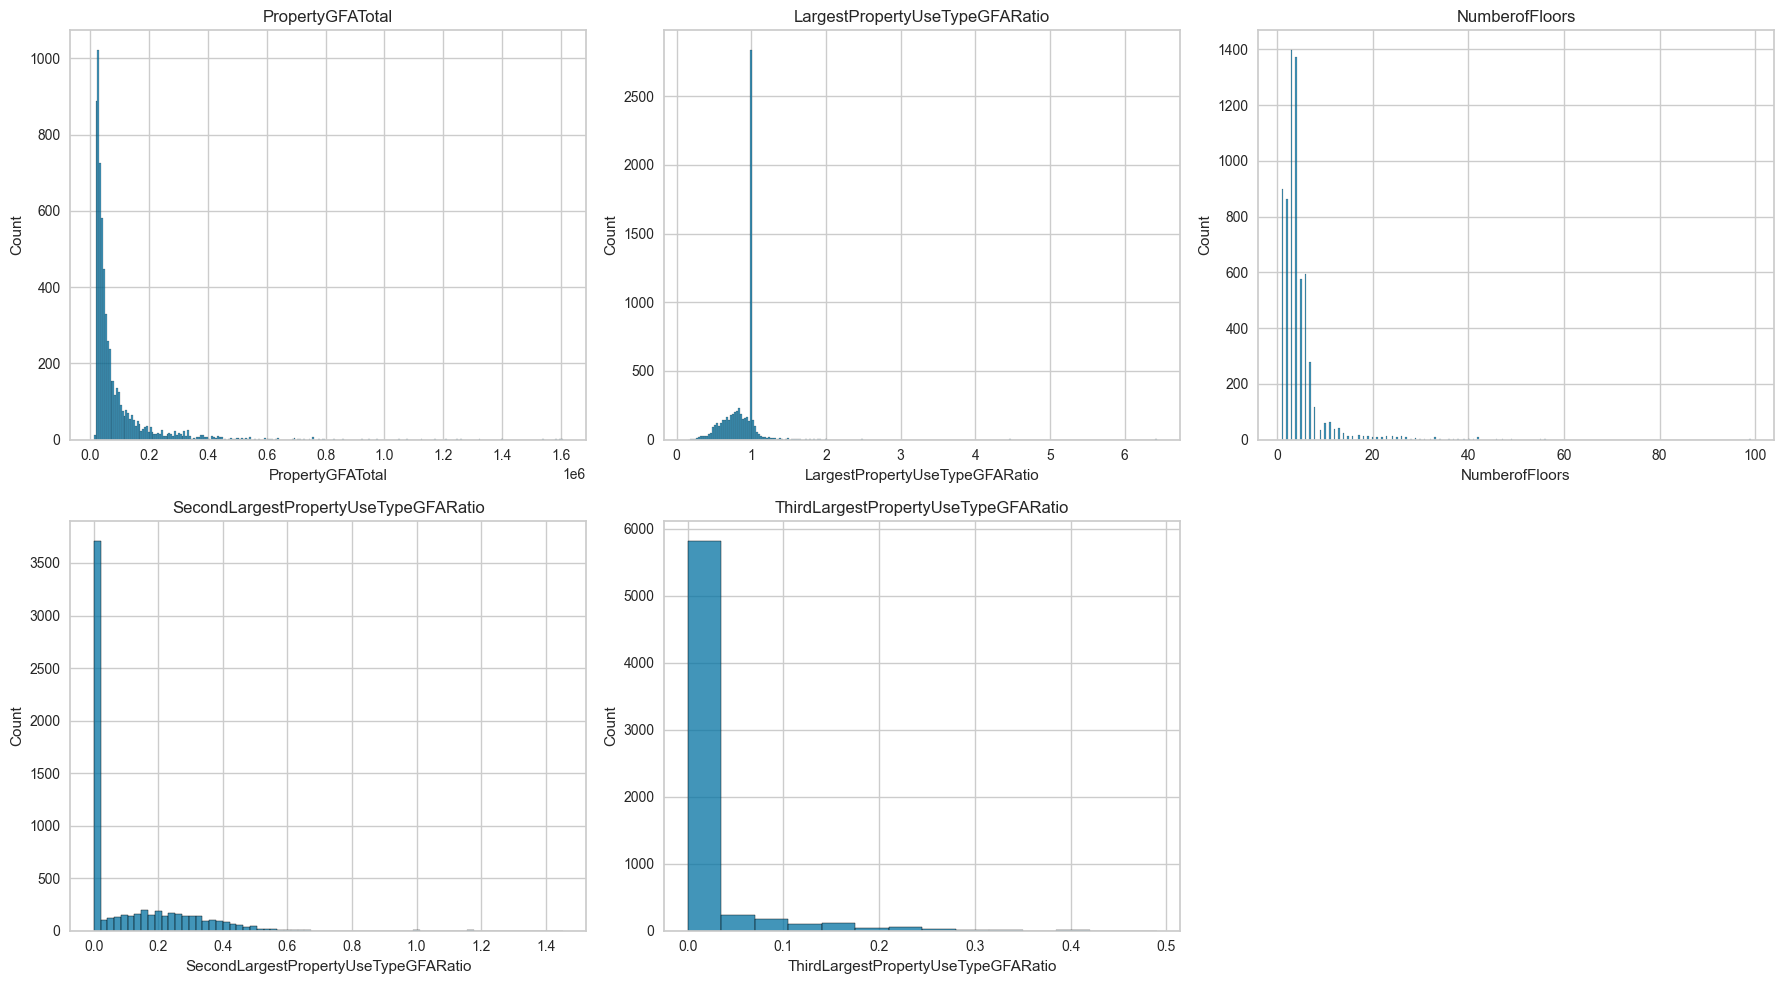

In [4]:
numerical_features = data.drop(TARGET_NAME, axis=1).select_dtypes(include=['float64', 'int64']).columns
numerical_data = data.loc[:, numerical_features]

num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols  # calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))  # adjust figsize as needed

for i, col in enumerate(numerical_features):
    row = i // num_cols
    col_pos = i % num_cols
    sns.histplot(numerical_data[col], kde=False, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col)

# Remove unused axes
for i in range(len(numerical_features), len(axes.flat)):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()

All five distributions in the image appear to be skewed. We are then going to use log transforms on the numerical features in the preprocessing pipeline for the model in order to decrease the skewness.


## Train/Test Split


In [5]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(TARGET_NAME, axis=1), data[TARGET_NAME], test_size=MODEL_PARAMS["TEST_SIZE"], random_state=SEED)

logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

2024-08-06 14:26:09.166 | INFO     | __main__:<module>:3 - 
X train: (5272, 7)
Y train: (5272,)
X test: (1319, 7)
Y test: (1319,)


## Training


In [6]:
df = x_train.copy()
df[TARGET_NAME] = np.log(y_train)

In [7]:
exp_reg = regression.setup(df, target=TARGET_NAME, max_encoding_ohe=200, log_experiment=True, experiment_name="building-energy-prediction-training", train_size=0.8)
regression.set_config('seed', SEED)

# Removing useless metrics improve training speed
regression.remove_metric('MAPE')
regression.remove_metric('MSE')
regression.remove_metric('RMSLE')

,Description,Value
0,Session id,1542
1,Target,SiteEnergyUse(kBtu)
2,Target type,Regression
3,Original data shape,"(5272, 8)"
4,Transformed data shape,"(5272, 67)"
5,Transformed train set shape,"(4217, 67)"
6,Transformed test set shape,"(1055, 67)"
7,Numeric features,5
8,Categorical features,2
9,Preprocess,True


In [8]:
best_threes_model = regression.compare_models(n_select=3)

,Model,MAE,RMSE,R2,TT (Sec)
et,Extra Trees Regressor,0.2560,0.4490,0.8312,0.3220
rf,Random Forest Regressor,0.2982,0.4589,0.8239,0.4140
xgboost,Extreme Gradient Boosting,0.3300,0.4789,0.8083,0.4680
lightgbm,Light Gradient Boosting Machine,0.3642,0.5147,0.7789,0.3860
gbr,Gradient Boosting Regressor,0.3860,0.5322,0.7634,0.1880
dt,Decision Tree Regressor,0.3067,0.5434,0.7525,0.0280
ada,AdaBoost Regressor,0.5138,0.6697,0.6257,0.1000
br,Bayesian Ridge,0.5238,0.6967,0.5953,0.0310
ridge,Ridge Regression,0.5238,0.6967,0.5952,0.0260
knn,K Neighbors Regressor,0.5221,0.6968,0.5943,0.0360


2024/08/06 14:26:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extra Trees Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/438d49a0999048d3b70be6ebd0e43d22.


2024/08/06 14:26:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/c5c75f762c994fe79b64753deded857b.


2024/08/06 14:26:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extreme Gradient Boosting at: http://localhost:8080/#/experiments/584040955558151400/runs/4416dd28ad88421b9cde21a94513ea5b.


2024/08/06 14:26:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://localhost:8080/#/experiments/584040955558151400/runs/577682cba1f342c7acc98bf005ab9667.


2024/08/06 14:26:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/4a9aa4d414794807b68f15e543e307f9.


2024/08/06 14:26:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:48 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run Decision Tree Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/75a8c5486f9e4e2b8796ef5751f297f4.


2024/08/06 14:26:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run AdaBoost Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/779448a065c144699ddd9f6ac0157bd1.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Bayesian Ridge at: http://localhost:8080/#/experiments/584040955558151400/runs/59348c713b4d4a4092e382ed84f6ada9.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run Ridge Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/1e05784854834fb492f6097a4036aca4.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run K Neighbors Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/e19290c9ac3f43dca3fc84a0af170b0a.


2024/08/06 14:26:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Linear Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/bae929ba45a3480d807c0ce550ff8dd2.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Orthogonal Matching Pursuit at: http://localhost:8080/#/experiments/584040955558151400/runs/409a447acaae48ecb32678a0979a1576.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lasso Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/7d0aa9bea4f94ba388df8ac5b46d8f4a.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run Elastic Net at: http://localhost:8080/#/experiments/584040955558151400/runs/210a04fe21e34749ad7e867fd2f2721a.


2024/08/06 14:26:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lasso Least Angle Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/ecfc8d279a51405a8428848f2fd85cfc.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/85d24989406c458faea78f81d1742f2b.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Huber Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/6a60e704c7e3462f8d1080bbc7a47c8b.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run Passive Aggressive Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/8c92ddff26eb4ca3a6f1f7ab2d13e717.


2024/08/06 14:26:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/06 14:26:52 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:26:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run Least Angle Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/385a1c7237204af1a6f176da09968236.


2024/08/06 14:26:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


In [9]:
mlflow.end_run()

2024/08/06 14:26:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session Initialized bdfb at: http://localhost:8080/#/experiments/584040955558151400/runs/3e3f5b6a9b284829a77f7435c73f9251.


2024/08/06 14:26:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


Training on multiple types of models with PyCaret shows that for this problem, the models: ExtraTreesRegressor, XGBRegressor, and RandomForestRegressor are the most suitable. However, we believe that the performance obtained during this initial training can be significantly improved. We will wait to do parameter tuning and obtain the final models before making a choice.


## Fine-Tuning


In [10]:
ESTIMATOR_PARAMS = {
    ExtraTreesRegressor.__name__: {
        "estimator": ExtraTreesRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    },
    RandomForestRegressor.__name__: {
        "estimator": RandomForestRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    },
    xgb.XGBRegressor.__name__: {
        "estimator": xgb.XGBRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    }
}

In [11]:
search_cvs = fine_tune_models(ESTIMATOR_PARAMS, x_train, y_train)

2024/08/06 14:30:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:30:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run ExtraTreesRegressor at: http://localhost:8080/#/experiments/558378607717202508/runs/5f62ee4ca47848fdb29a2f2816f3abfe.


2024/08/06 14:30:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


2024/08/06 14:33:09 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:33:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForestRegressor at: http://localhost:8080/#/experiments/558378607717202508/runs/5befaaac5f9846c6bed99f818903e2e9.


2024/08/06 14:33:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


2024/08/06 14:33:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/06 14:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/558378607717202508/runs/0cd487b356ea4effb6ad413307d7ca9b.


2024/08/06 14:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


2024/08/06 14:33:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session-20240806_140852 at: http://localhost:8080/#/experiments/558378607717202508/runs/222d8e58d9974553af5f3c5457de77a8.


2024/08/06 14:33:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


## Model Evaluation on Test Data


We are going to evaluate the fine-tuned models to see which one we are going to pick as the final model.


In [12]:
# Obtaining best_models after fine-tuning
models = { f"{estimator_name}": search_cv.best_estimator_ for estimator_name, search_cv in search_cvs.items()}

In [13]:
# Get best estimator found after evaluation
best_estimator, score = evaluate_models(models, x_train, x_test, y_train, y_test)
logger.info(f"""{best_estimator} is the best estimator found for this problem with an R2 score of {score}""")

2024/08/06 14:33:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024-08-06 14:33:40.504 | INFO     | evaluate:evaluate_models:56 - ExtraTreesRegressor performance 
               rmse            mae        r2      maxerror
train  4.801639e+05   87260.848678  0.995088  2.919762e+07
test   2.770619e+06  854089.461448  0.866824  3.627865e+07


2024/08/06 14:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run ExtraTreesRegressor at: http://localhost:8080/#/experiments/109946002118914662/runs/c104515a418c427e8b0d09eb7e148832.


2024/08/06 14:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024/08/06 14:33:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024-08-06 14:33:42.553 | INFO     | evaluate:evaluate_models:56 - RandomForestRegressor performance 
               rmse           mae        r2      maxerror
train  1.427465e+06  4.386728e+05  0.956588  3.180475e+07
test   3.154096e+06  1.137564e+06  0.827408  3.669418e+07


2024/08/06 14:33:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForestRegressor at: http://localhost:8080/#/experiments/109946002118914662/runs/7edec6cd9ec54187be9e85b12cd4e273.


2024/08/06 14:33:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024/08/06 14:33:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024-08-06 14:33:44.305 | INFO     | evaluate:evaluate_models:56 - XGBRegressor performance 
               rmse           mae        r2    maxerror
train  1.286937e+06  5.352352e+05  0.964714  32104982.5
test   3.117946e+06  1.157940e+06  0.831341  37274722.5


2024/08/06 14:33:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/109946002118914662/runs/3558705be170413893fc9c9c4c86a205.


2024/08/06 14:33:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024/08/06 14:33:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session-20240806_140838 at: http://localhost:8080/#/experiments/109946002118914662/runs/0e6efce1eb87474fb53121170d74e82e.


2024/08/06 14:33:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024-08-06 14:33:44.337 | INFO     | __main__:<module>:3 - ExtraTreesRegressor is the best estimator found for this problem with an R2 score of 0.8668243493193665


After evaluation, we arrive at the conclusion that the best model for this problem is the **Extra Trees Regressor**. Before deploying the model, the best parameters will be picked for the model registry.


### Prediction Error Plot


Prediction plot for estimator ExtraTreesRegressor


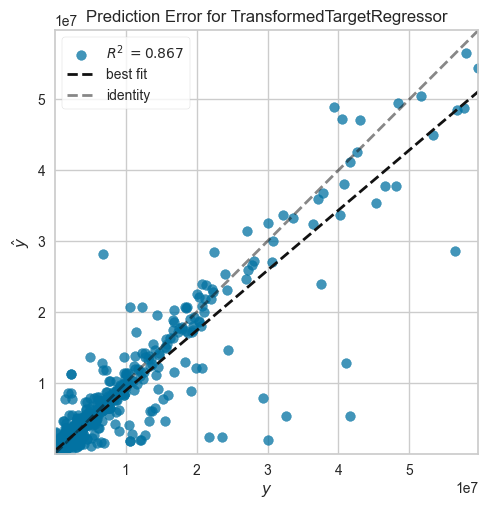

Prediction plot for estimator RandomForestRegressor


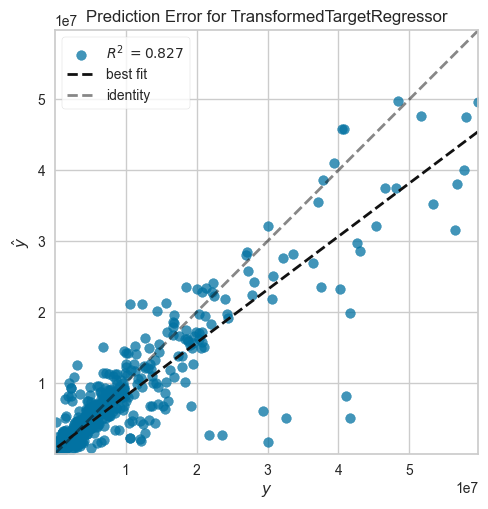

Prediction plot for estimator XGBRegressor


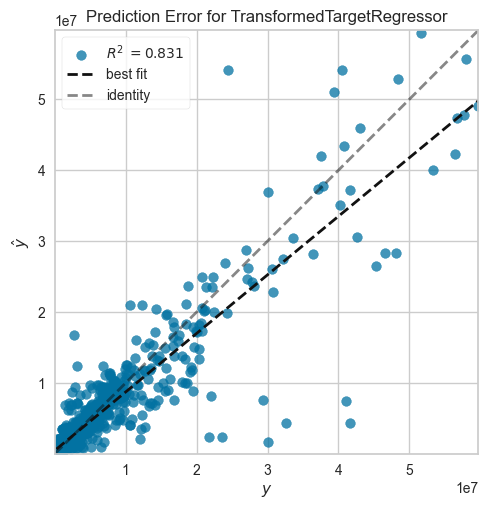

In [14]:
prediction_error_plot(models, x_train, x_test, y_train, y_test)

### Residual Plot


Residual plot for estimator ExtraTreesRegressor


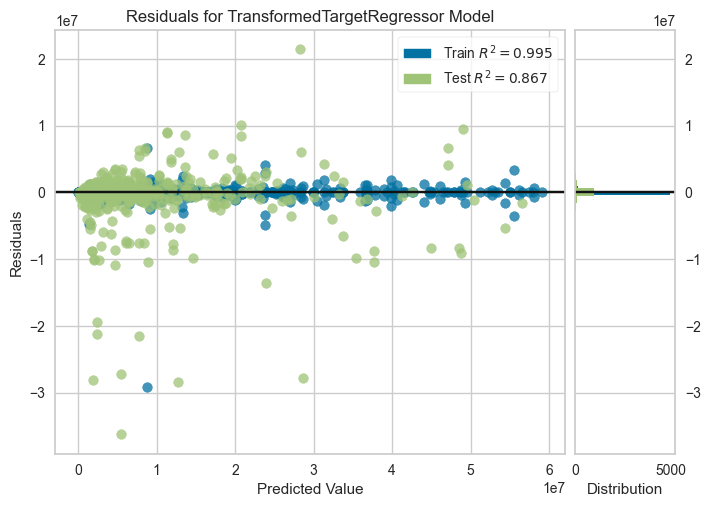

Residual plot for estimator RandomForestRegressor


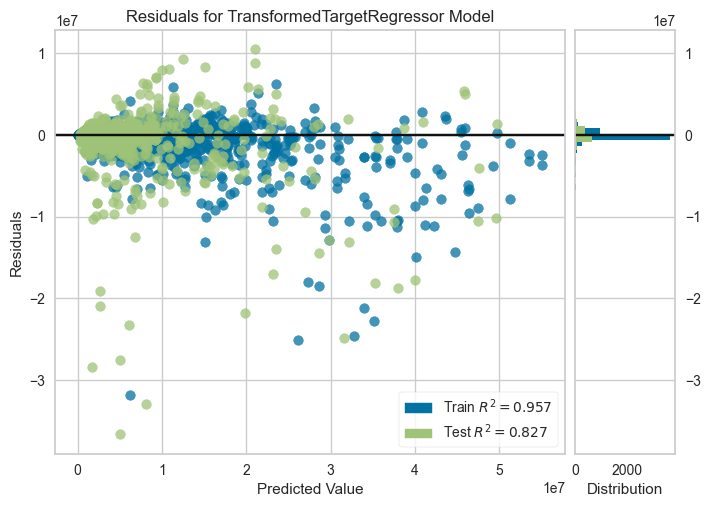

Residual plot for estimator XGBRegressor


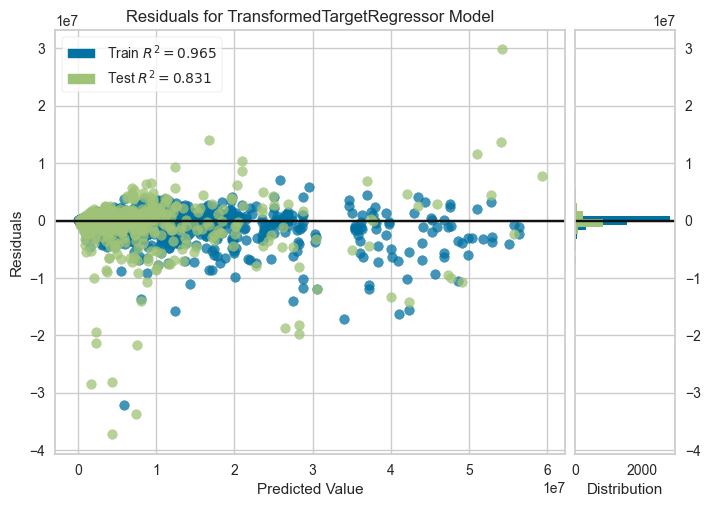

In [15]:
residual_plot(models, x_train, x_test, y_train, y_test)